In [1]:
import tensorflow as tf
import os

In [2]:
# set GPU consumption limit
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Remove bad images

In [3]:
import cv2
import imghdr

In [4]:
# some useful variables
data = os.path.join('data', 'training_set')
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [5]:
for image_class in os.listdir(data):
    for image in os.listdir(os.path.join(data, image_class)):
        image_path = os.path.join(data, image_class, image)

        try:
            tip = imghdr.what(image_path) # gets extension

            if tip not in image_exts:
                print(f'Image not in ext list {image_exts}')
                os.remove(image_path)
        except Exception as e:
            print(f'Issue with image {image_path}')
            os.remove(image_path)

In [12]:
import numpy as np
from matplotlib import pyplot as plt

In [13]:
# this helps automatically load all the image into a dataset and also the labels as well and it resizes the image to 256 by 256 pixels
data = tf.keras.utils.image_dataset_from_directory(os.path.join('data', 'training_set'))

Found 8005 files belonging to 2 classes.


In [14]:
data_iterator = data.as_numpy_iterator()

In [15]:
batch = data_iterator.next()

In [16]:
# data has two parts first part is the images second is the labels
len(batch)

2

In [17]:
# this provides 32 images per batch, resized to 256 by 256 pixels and 3 channels (colored images)
batch[0].shape

(32, 256, 256, 3)

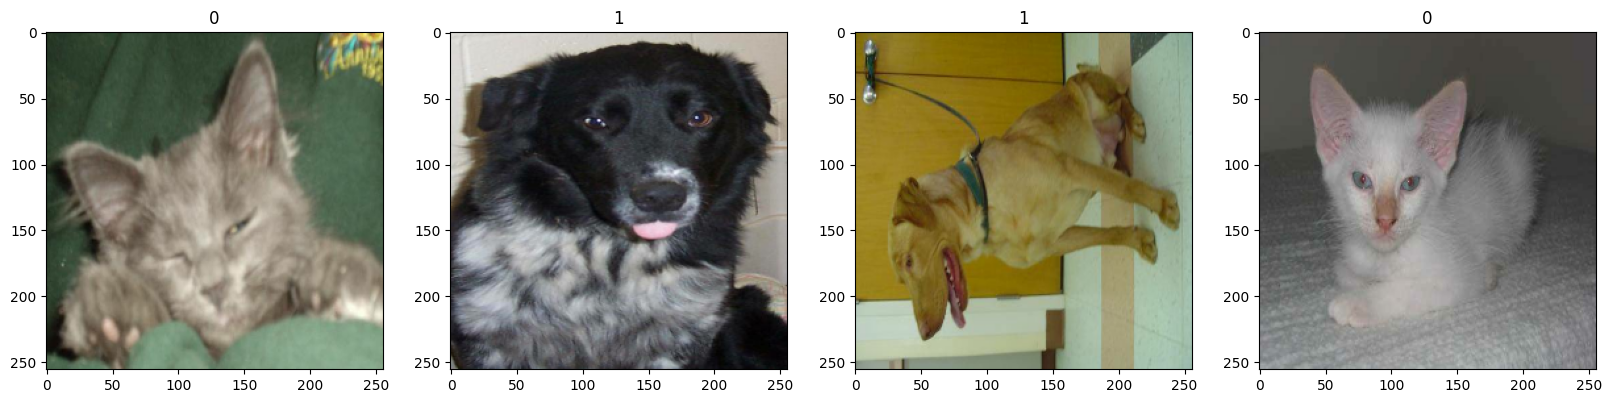

In [18]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### from the above you can see that cats are 0 and dogs are 1

## Prepocessing

In [19]:
# scale the data from 0 to 255 to 0 and 1

# x is the image
# y is the labels 

# this function makes sure as new batches come in they are scaled
data = data.map(lambda x, y: (x/255, y))

In [20]:
scaled_data = data.as_numpy_iterator()

In [21]:
batch = scaled_data.next()

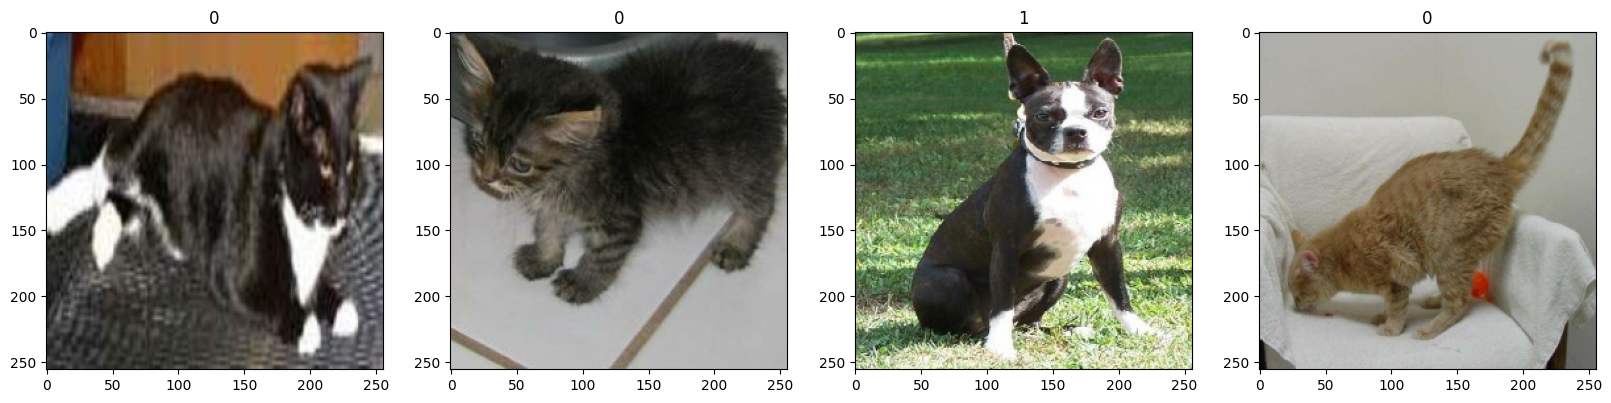

In [22]:
# plotting function
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(float)) 
    # I am changing this to float because since we scaled if we convert to int it will all be 0
    ax[idx].title.set_text(batch[1][idx])

## Deep learning

In [23]:
test_data = tf.keras.utils.image_dataset_from_directory(os.path.join('data', 'test_set'))
test_data = test_data

test_data = test_data.map(lambda x, y: (x/256, y)) # scale it

Found 2023 files belonging to 2 classes.


In [24]:
# since my data is already split up I need to just take all the training data and all the validation data

train = data.take(len(data))
val = test_data.take(int(len(test_data) * .8))
test = test_data.take(int(len(test_data) * .2))

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [35]:
# first parameter in conv2d represents number of features to extract
# Also this builds the deep neural network
model = Sequential([
  Conv2D(16, (3,3), 1, activation='relu', input_shape=(256, 256, 3)),
  MaxPooling2D(),

  Conv2D(32, (3,3), 1, activation='relu'),
  MaxPooling2D(),

  Conv2D(16, (3,3), 1, activation='relu'),
  MaxPooling2D(),

  Flatten(),
  Dropout(0.3),
  Dense(512, activation='relu'),
  Dropout(0.3),
  Dense(256, activation='relu'),
  Dropout(0.3),
  Dense(256, activation='relu'),
  Dense(1, activation='sigmoid')
])

In [36]:
model.compile(
    optimizer='adam',
    loss=tf.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 30, 16)      

In [38]:
logdir = 'logs'

In [39]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [40]:
early_stopping = tf.keras.callbacks.EarlyStopping(
        min_delta=0.01,
        patience=5,
        restore_best_weights=True
    )

In [41]:
hist = model.fit(
    train,
    epochs=20,
    validation_data=val,
    callbacks=[tensorboard_callback, early_stopping]
)

Epoch 1/20
251/251 [==============================] - 14s 55ms/step - loss: 0.6857 - accuracy: 0.5473 - val_loss: 0.6646 - val_accuracy: 0.6036
Epoch 2/20
251/251 [==============================] - 13s 53ms/step - loss: 0.6337 - accuracy: 0.6478 - val_loss: 0.6554 - val_accuracy: 0.6446
Epoch 3/20
251/251 [==============================] - 13s 53ms/step - loss: 0.5528 - accuracy: 0.7197 - val_loss: 0.7103 - val_accuracy: 0.6648
Epoch 4/20
251/251 [==============================] - 13s 53ms/step - loss: 0.5009 - accuracy: 0.7547 - val_loss: 0.6103 - val_accuracy: 0.6857
Epoch 5/20
251/251 [==============================] - 14s 54ms/step - loss: 0.4083 - accuracy: 0.8159 - val_loss: 0.6349 - val_accuracy: 0.7040
Epoch 6/20
251/251 [==============================] - 14s 54ms/step - loss: 0.3260 - accuracy: 0.8556 - val_loss: 0.6447 - val_accuracy: 0.6979
Epoch 7/20
251/251 [==============================] - 14s 54ms/step - loss: 0.2257 - accuracy: 0.9114 - val_loss: 0.9133 - val_accuracy:

## Analyze performance

In [44]:
hist.history

{'loss': [0.6857276558876038,
  0.633746862411499,
  0.5528178215026855,
  0.5009459853172302,
  0.40833738446235657,
  0.325989693403244,
  0.22569437325000763,
  0.15499085187911987,
  0.1034405305981636],
 'accuracy': [0.5472829341888428,
  0.6478450894355774,
  0.7196751832962036,
  0.7546533346176147,
  0.8158650994300842,
  0.855590283870697,
  0.9114303588867188,
  0.9430356025695801,
  0.9625234007835388],
 'val_loss': [0.6646465063095093,
  0.6554237604141235,
  0.7103098034858704,
  0.6102752089500427,
  0.6348502039909363,
  0.6446816921234131,
  0.9132855534553528,
  0.9522638320922852,
  0.918923556804657],
 'val_accuracy': [0.6035539507865906,
  0.6446078419685364,
  0.6648284196853638,
  0.685661792755127,
  0.7040441036224365,
  0.6979166865348816,
  0.7083333134651184,
  0.719975471496582,
  0.7297794222831726]}

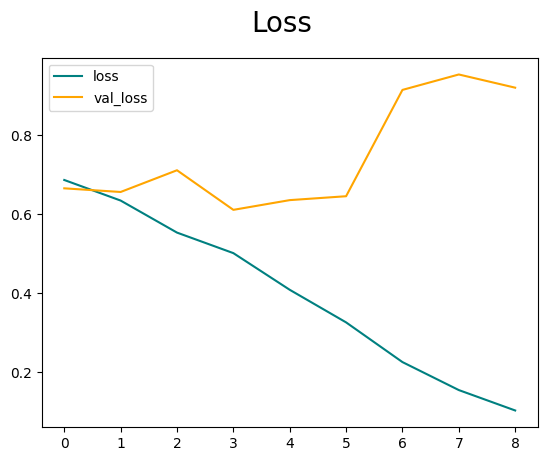

In [45]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

## model is overfitting not sure how to correct right now

In [46]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [47]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [48]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 16ms/step


In [49]:
print(f"Precision {pre.result().numpy()}, Recall {re.result().numpy()}, Accuracy: {acc.result().numpy()}")

Precision 0.7219251394271851, Recall 0.6650246381759644, Accuracy: 0.6875


In [51]:
# Testing with some extra data
import cv2

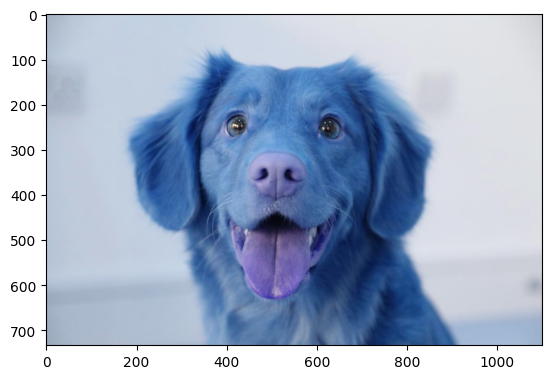

In [100]:
img = cv2.imread(os.path.join('data', 'dog.jpeg'))
plt.imshow(img)
plt.show()

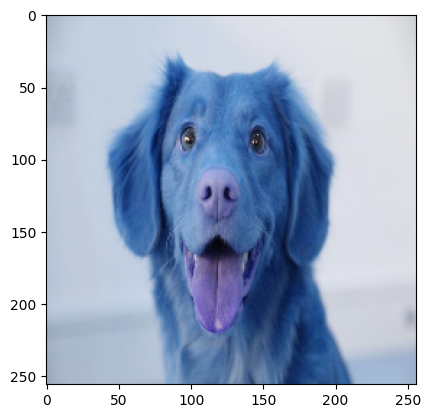

In [101]:
# resize image
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [102]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 16ms/step


In [103]:
yhat

array([[0.7469323]], dtype=float32)

In [104]:
if yhat > 0.5:
    print('Predicted class is Dog')
else:
    print('Predicted class is Cat')

Predicted class is Dog


In [105]:
from tensorflow.keras.models import load_model

In [106]:
model.save(os.path.join('models', 'catdogmodel.h5'))

In [108]:
# in order to load it this is how to do it
new_model = load_model(os.path.join('models', 'catdogmodel.h5'))

In [109]:
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 83ms/step


In [110]:
yhatnew

array([[0.7469323]], dtype=float32)